### Cab-Driver Agent

#### Aim:
 RL-based system for assisting cab drivers which can help cab drivers maximise their profits by improving their decision-making process on the field and can potentially retain and attract new cab drivers

In [67]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# for plotting graphs
import matplotlib.pyplot as plt

<b>Environment parameters<b>

In [68]:
#Number of Cities
m = 5
#Number of hours
t = 24
#Number of days
d = 7
#Cost per kilometer
C = 5#25
#Revenue per kilometer
R = 9#30

#### Defining Time Matrix

In [69]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [70]:
states_track = collections.defaultdict(dict)

#### Tracking the state-action pairs for checking convergence


In [71]:
Q1 = ((2,2,2),(3,2))
Q2 = ((3,10,6),(3,4))
Q3 = ((0,20,3),(1,4))
Q4 = ((3,0,2),(3,1))
def initialise_tracking_states():
    sample_q_values = [Q1,Q2,Q3,Q4]
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        states_track[state][action] = []

In [72]:
# initialising all the state-action pairs tracked
initialise_tracking_states()

In [73]:
#Function to check convergence
def save_tracking_states():
    for state in states_track.keys():
        for action in states_track[state].keys():
            Q = agent.prediction([action], state)
            states_track[state][action].append(Q)  

In [74]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Agent Class

In [75]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        
        
        # Define size of state and action
        self.state_size = m+t+d
        self.action_size = m*(m-1) + 1
        
        self.action_space = [[i,j] for i in range(m) for j in range(m) if i!=j or i==0]

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001       
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00000001
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
    
    def prediction(self, action, state):
        X_test = np.zeros((len(action), 46))
        for i in range(len(action)):
            dummy = env.state_encod_arch2(state, action[i])
            X_test[i,:] = dummy
        prediction = self.model.predict(X_test)
        prediction = prediction.reshape(len(action))
        return prediction

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        model.add(Dense(200, input_dim = 46,activation ='relu'))
        model.add(Dense(150,activation ='relu'))
        model.add(Dense(100,activation ='relu'))
        model.add(Dense(1,activation ='linear'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

     # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment  
    def get_action(self, state, episode):
        poss_actions_index, poss_actions = env.requests(state)
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)
        
        # Randomly choosing and action->Exploration
        if np.random.rand() <= epsilon:      
            action_index = np.random.choice(poss_actions_index)
            action = self.action_space[action_index]
        else: #This gets the action corresponding to max q-value of current state->Exploitation
            q_value = self.prediction(poss_actions, state)
            action_index = np.argmax(q_value)
            action = poss_actions[action_index]
        return action, epsilon
            
        
    

    def append_sample(self, state, action, reward, next_state, terminal_state):
        self.memory.append((state, action, reward, next_state, terminal_state))
        # save sample <s,a,r,s'> to the replay memory
    

    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
  

        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from the memory
        mini_batch = random.sample(self.memory, self.batch_size)
        update_input = np.zeros((self.batch_size, 46))
        update_output = np.zeros((self.batch_size, self.action_size))

        actions, rewards, terminal_states = [], [], []

        
        
        for i in range(self.batch_size):
            
            state, action, reward, next_state, terminal_state = mini_batch[i]
            
            actions.append(self.action_space.index(action))
            rewards.append(reward)
            terminal_states.append(terminal_state)
            

            update_input[i] = env.state_encod_arch2(state, action)
            update_output[i,:]= self.prediction(self.action_space, next_state)
        
        target = np.zeros((self.batch_size))
        # get your target Q-value on the basis of terminal state
        for i in range(self.batch_size):
            if terminal_states[i]:
                #print(True)
                target[i] = rewards[i]
                
            else:
                target[i] = rewards[i] + self.discount_factor * (np.amax(update_output[i]))

        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
                       
                

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [76]:
Episodes = 1000

### DQN block

In [77]:
# Importing the environment
from Env import CabDriver

In [78]:
# Initialising the environment
env = CabDriver()

In [79]:
# Get size of state and action from environment
state_size = len(env.state_space)
action_size = len(env.action_space)

In [80]:
# Agent needs to be initialised outside the loop since the DQN network will be initialised along with the agent
agent = DQNAgent(state_size, action_size)

In [81]:
# Tracking average and total rewards reward per episode
avg_reward,total_reward = [],[]
start_time = time.time()

In [82]:
for episode in range(Episodes):
    # tracking Step count,Total rewards
    tot_reward = 0
    step_count = 0
    state = env.reset()
    terminal_state = False
  
       
    while not terminal_state:
        
        action, epsilon = agent.get_action(state, episode)
        reward = env.reward_func(state, action, Time_matrix)
        
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        
        # every time step do the training
        agent.train_model()
        tot_reward += reward
        state = next_state
        step_count += 1
        
        # Store the rewards
        if terminal_state and episode % 100 ==0:
            avg_reward.append(tot_reward/step_count)
            total_reward.append(tot_reward)
            print("episode:", episode, "  score:", tot_reward, "  memory length:",
                      len(agent.memory), "  epsilon:", epsilon)
            

   
    if episode % 100 == 0:
        agent.save(name="model.pkl")
        elapsed_time = time.time() - start_time
        save_tracking_states()
        save_obj(states_track,'States_tracked')  
        print('Total time taken ',round(elapsed_time,2),'s')
        
    
    if episode % 1000 == 0 and episode !=0:
        plt.plot(list(range(len(avg_reward))), avg_reward)
        plt.show()
        

episode: 0   score: -146.0   memory length: 158   epsilon: 1.0
Total time taken  136.98 s
episode: 100   score: 72.0   memory length: 2000   epsilon: 0.9704455338440529
Total time taken  15364.24 s
episode: 200   score: -216.0   memory length: 2000   epsilon: 0.9417645341666034
Total time taken  31045.35 s
episode: 300   score: -93.0   memory length: 2000   epsilon: 0.9139311861319164
Total time taken  46716.83 s
episode: 400   score: 8.0   memory length: 2000   epsilon: 0.8869204378479532
Total time taken  72932.81 s
episode: 500   score: -281.0   memory length: 2000   epsilon: 0.860707977817978
Total time taken  91399.49 s
episode: 600   score: 74.0   memory length: 2000   epsilon: 0.8352702130585699
Total time taken  107154.21 s
episode: 700   score: 108.0   memory length: 2000   epsilon: 0.8105842478643446
Total time taken  122374.99 s
episode: 800   score: 180.0   memory length: 2000   epsilon: 0.7866278632002749
Total time taken  136952.66 s
episode: 900   score: 285.0   memory l

### Reward Plots

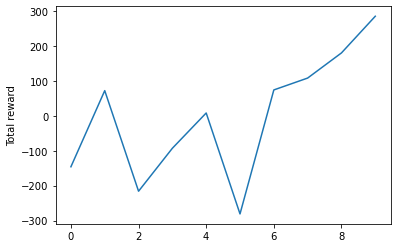

In [83]:
# Plotting Total rewards
plt.plot(list(range(len(total_reward))), total_reward)
plt.ylabel("Total reward")
plt.show()

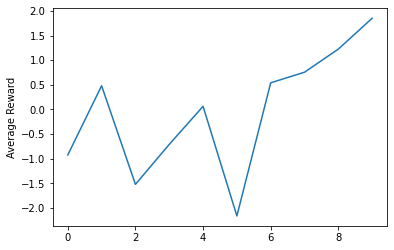

In [84]:
# Plotting average rewards. Tracked after every 100 episodes
plt.plot(list(range(len(avg_reward))), avg_reward)
plt.ylabel("Average Reward")
plt.show()

#### Q-Values Plots

<function matplotlib.pyplot.show(*args, **kw)>

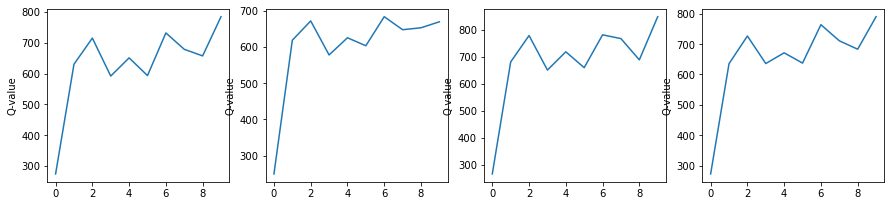

In [96]:
plt.figure(0, figsize=(15,7))

#Q1
xaxis = np.asarray(range(len(states_track[(2, 2, 2)][(3,2)])))
plt.subplot(241)
plt.plot(xaxis,np.asarray(states_track[(2,2,2)][(3,2)]))
plt.ylabel("Q-value")
plt.show

#Q2
xaxis = np.asarray(range(len(states_track[(3,10,6)][(3,4)])))
plt.subplot(242)
plt.plot(xaxis,np.asarray(states_track[(3,10,6)][(3,4)]))
plt.ylabel("Q-value")
plt.show

#Q3
xaxis = np.asarray(range(len(states_track[(0,20,3)][(1,4)])))
plt.subplot(243)
plt.plot(xaxis,np.asarray(states_track[(0,20,3)][(1,4)]))
plt.ylabel("Q-value")
plt.show

#Q4
xaxis = np.asarray(range(len(states_track[(3,0,2)][(3,1)])))
plt.subplot(244)
plt.plot(xaxis,np.asarray(states_track[(3,0,2)][(3,1)]))
plt.ylabel("Q-value")
plt.show

In [88]:
range(len(states_track[(3,0,2)][(3,1)]))

range(0, 10)

In [100]:
states_track[(3,0,2)][(3,1)]

[array([272.64444], dtype=float32),
 array([635.4605], dtype=float32),
 array([726.60114], dtype=float32),
 array([635.99524], dtype=float32),
 array([671.31244], dtype=float32),
 array([637.4653], dtype=float32),
 array([763.8561], dtype=float32),
 array([710.89105], dtype=float32),
 array([683.1288], dtype=float32),
 array([790.1893], dtype=float32)]

#### Epsilon-decay sample function

In [103]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

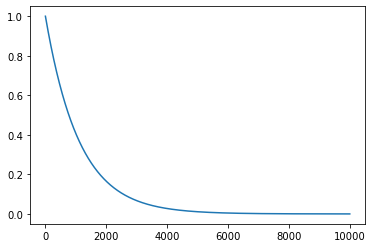

In [104]:
plt.plot(time, epsilon)
plt.show()